In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Define the model.

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {DEVICE} device")

using cuda device


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()  
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
        )
    
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()  
        self.downs = nn.ModuleList()  
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size = 2, stride = 2))
            self.ups.append(DoubleConv(feature * 2, feature))
        
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:  
                x = TF.resize(x, size = skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim = 1) 
            x = self.ups[idx + 1](concat_skip)

        x = self.final_conv(x)

        return x


In [ ]:
def testmodel():
    x = torch.randn((16, 3, 128, 256)).to(DEVICE)
    model = UNet(in_channels = 3, out_channels = 34).to(DEVICE)
    pred = model(x)
    print(pred.shape)
    
if __name__ == "__main__":
    testmodel()

torch.Size([16, 34, 128, 256])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 2. Load the data.

In [ ]:
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
class CityScapesData(Dataset):
    def __init__(self, filepath):
        h5File = h5py.File(filepath, 'r')
        self.color_codes = torch.tensor(np.array(h5File['color_codes'], dtype = "uint8"))
        self.rgb = torch.tensor(np.array(h5File['rgb'], dtype = "uint8"))  # 注意要先转换成 torch 的张量 才能用 permute
        self.rgb = self.rgb.permute(0, 3, 1, 2)  # 转换一下维度顺序 便于载入网络 与标签对应 -> shape = 2975 3 128 256
        self.seg = torch.tensor(np.array(h5File['seg'], dtype = "uint8").squeeze())

    def __len__(self):
        return len(self.rgb)
        
    def __getitem__(self, index): 
        image = self.rgb[index]
        target = self.seg[index]
            
        return image, target

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm  

# -----------
EPOCHS = 10
LR = 0.01
# -----------

model = UNet(out_channels = 34).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)

## 3. Train.

In [ ]:
stepLosses = []
epochLosses = []
for epoch in tqdm(range(EPOCHS)):
    epochLoss = 0
    for X, Y in tqdm(trainLoader, total = len(trainLoader), leave=False):
        X, Y = X.to(device = DEVICE, dtype = torch.float), Y.to(device = DEVICE, dtype = torch.long)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epochLoss += loss.item()
        print(loss.item())
        stepLosses.append(loss.item())
    epochLosses.append(epochLoss/len(trainLoader))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

3.6299149990081787
3.2284605503082275
2.711412191390991
2.225113868713379
2.4287500381469727
1.915139079093933
2.022348642349243
1.570217490196228
1.657926082611084
1.8698760271072388
1.7157171964645386
1.7384445667266846
1.7163394689559937
1.8637195825576782
1.5634719133377075
1.5334947109222412
1.5769703388214111
1.5156716108322144
1.532078742980957
1.997540831565857
1.6503113508224487
1.7325961589813232
1.6330337524414062
1.7215818166732788
1.5941070318222046
1.5819029808044434
1.5392447710037231
1.833536148071289
1.523041009902954
1.4499326944351196
1.3927611112594604
1.450355052947998
1.3425133228302002
1.294753074645996
1.3149104118347168
1.3978545665740967
1.1991915702819824
1.2577931880950928
1.313494324684143
1.1710498332977295
1.2584160566329956
1.2550288438796997
1.2898257970809937
1.310608148574829
1.2453114986419678
1.0131269693374634
1.0438474416732788
1.2693196535110474
1.123819351196289
1.0421603918075562
1.1052900552749634
1.131596326828003
1.0772652626037598
1.1716390

  0%|          | 0/186 [00:00<?, ?it/s]

1.0530142784118652
1.151536464691162
1.0013659000396729
0.8720832467079163
1.3277961015701294
0.9547141790390015
1.1986491680145264
0.819346010684967
0.8731459379196167
1.114536166191101
0.9852535128593445
1.0245423316955566
1.046067237854004
1.146012306213379
0.9398038387298584
1.0069255828857422
0.9922264814376831
0.9690775275230408
0.9926887154579163
1.412733554840088
1.0094866752624512
1.0610932111740112
1.070267915725708
1.0973806381225586
0.9801653027534485
1.0106734037399292
1.0183390378952026
1.2789463996887207
0.9952378273010254
0.9519657492637634
0.9121333360671997
1.147083044052124
1.055592656135559
1.01067054271698
1.003780484199524
1.1313620805740356
0.946244478225708
0.926064133644104
1.0394363403320312
0.8925078511238098
1.0133477449417114
1.0063949823379517
1.0675519704818726
1.0578956604003906
0.9501748085021973
0.8341889977455139
0.8409011363983154
1.0154982805252075
0.9180890321731567
0.8648204803466797
0.8783252835273743
0.9319787621498108
0.8455055356025696
1.00234

  0%|          | 0/186 [00:00<?, ?it/s]

1.069007396697998
1.1830590963363647
0.9058836698532104
0.7732780575752258
1.205236554145813
0.9510683417320251
1.1308503150939941
0.7604661583900452
0.7980178594589233
1.0167049169540405
0.9267687201499939
0.9808434247970581
1.0056779384613037
1.0945700407028198
0.8795279860496521
0.9072367548942566
0.9230484366416931
0.8711497783660889
0.8933417201042175
1.311118721961975
0.9336436986923218
0.9661853313446045
0.9539846777915955
0.9807785749435425
0.9306553602218628
0.9529663324356079
0.9478301405906677
1.247110366821289
0.9176298975944519
0.8830304145812988
0.8302183151245117
1.0857080221176147
0.9673163294792175
0.9496023058891296
0.9400956034660339
1.0627347230911255
0.8936322331428528
0.8462489247322083
0.9716222286224365
0.8219287395477295
0.9359230995178223
0.9169123768806458
0.9944260716438293
1.009660243988037
0.8901020884513855
0.7553509473800659
0.7594929933547974
0.9376128315925598
0.8414216637611389
0.7817318439483643
0.7931946516036987
0.8319926857948303
0.782690763473510

  0%|          | 0/186 [00:00<?, ?it/s]

0.9282165765762329
1.0769604444503784
0.8896487355232239
0.7093515992164612
1.0991852283477783
0.8443765640258789
1.036519169807434
0.6871293783187866
0.7598838210105896
0.9655482769012451
0.8560328483581543
0.9109416604042053
0.963219165802002
1.0842359066009521
0.8535060882568359
0.8925116658210754
0.9030216336250305
0.8120586276054382
0.8459575176239014
1.2394769191741943
0.9079413414001465
0.9367411136627197
0.9256726503372192
0.9361750483512878
0.8948221206665039
0.9190671443939209
0.9073199033737183
1.2240523099899292
0.9016948342323303
0.9024442434310913
0.7944418787956238
1.0901473760604858
0.9567355513572693
0.922595202922821
0.9071682095527649
1.0653095245361328
0.8890255093574524
0.8274035453796387
0.9437237977981567
0.796911895275116
0.8976236581802368
0.9111973643302917
0.9835550785064697
0.9830034971237183
0.8591024279594421
0.7338271737098694
0.7332959175109863
0.9016841650009155
0.7906863689422607
0.7510272264480591
0.7586922645568848
0.7934104800224304
0.74369889497756

  0%|          | 0/186 [00:00<?, ?it/s]

0.8909055590629578
0.9803160429000854
0.7778515815734863
0.6573085784912109
1.005374550819397
0.8107092976570129
0.9951433539390564
0.660874605178833
0.7356055378913879
0.914027214050293
0.8351545929908752
0.866254985332489
0.9165093302726746
1.0193781852722168
0.8117438554763794
0.888228714466095
0.858984112739563
0.7860149145126343
0.8164435625076294
1.1880751848220825
0.8718064427375793
0.893699586391449
0.8908717036247253
0.9122771620750427
0.8821867108345032
0.9009780883789062
0.8908189535140991
1.1695080995559692
0.8618054389953613
0.8848288059234619
0.7553096413612366
1.0472989082336426
0.9124138951301575
0.8767895102500916
0.8437840342521667
1.0120431184768677
0.8629907369613647
0.8099936842918396
0.9203671813011169
0.7707902193069458
0.8651601076126099
0.8688832521438599
0.9411777853965759
0.9460551142692566
0.8241473436355591
0.6990640163421631
0.7036367654800415
0.8736091256141663
0.7702903151512146
0.7061436176300049
0.739470362663269
0.7786697745323181
0.7158284783363342
0

  0%|          | 0/186 [00:00<?, ?it/s]

0.8498145341873169
0.9781906604766846
0.7899296879768372
0.67802494764328
0.9981469511985779
0.7994687557220459
0.9575831890106201
0.6376100778579712
0.715842604637146
0.9293248653411865
0.8213832974433899
0.8563200831413269
0.8787093162536621
0.985413134098053
0.7761926054954529
0.8546915054321289
0.8616476655006409
0.7928888201713562
0.8004371523857117
1.2033604383468628
0.8764680027961731
0.8853093385696411
0.8826169371604919
0.8877387046813965
0.8392701148986816
0.8697847127914429
0.8670352697372437
1.1451178789138794
0.8606101274490356
0.8418058156967163
0.7508829832077026
1.0385304689407349
0.8981558680534363
0.8532561659812927
0.824060320854187
0.9770054221153259
0.8194230198860168
0.7817797660827637
0.873834490776062
0.7576413750648499
0.8670819401741028
0.8662506937980652
0.9254083037376404
0.9431037902832031
0.7958977222442627
0.6796059608459473
0.6986982822418213
0.8529140949249268
0.750028669834137
0.7011865377426147
0.7245877981185913
0.7535971403121948
0.6942229866981506


  0%|          | 0/186 [00:00<?, ?it/s]

0.8303496241569519
0.9717848300933838
0.7602055668830872
0.6596583127975464
0.9662831425666809
0.7725957632064819
0.9199497699737549
0.6226997375488281
0.6818102598190308
0.9038513898849487
0.8162720203399658
0.8502210378646851
0.871844470500946
0.9686712026596069
0.757215678691864
0.816855788230896
0.8296912908554077
0.7602369785308838
0.7804809212684631
1.1799556016921997
0.8583118915557861
0.8596431016921997
0.865450382232666
0.8795969486236572
0.8059029579162598
0.8181674480438232
0.8248993754386902
1.0987282991409302
0.8239500522613525
0.7942104935646057
0.7155246138572693
0.9937683343887329
0.8638875484466553
0.8161731958389282
0.8004565238952637
0.9409050941467285
0.8050885796546936
0.7551001310348511
0.8477460145950317
0.7341485023498535
0.8418689966201782
0.8274362087249756
0.8755527138710022
0.9162906408309937
0.7689526081085205
0.6407617330551147
0.6526152491569519
0.8404964208602905
0.7233510613441467
0.6820712685585022
0.6999971866607666
0.7279123663902283
0.66461461782455

  0%|          | 0/186 [00:00<?, ?it/s]

0.8150818347930908
0.930770218372345
0.7426820993423462
0.629490315914154
0.9717726111412048
0.7682899236679077
0.9397241473197937
0.6050231456756592
0.6400273442268372
0.8868993520736694
0.8176779747009277
0.8020472526550293
0.8416191339492798
0.932802140712738
0.7116822600364685
0.7785083055496216
0.8052238821983337
0.7473238110542297
0.7527336478233337
1.142079472541809
0.8325397968292236
0.8363766670227051
0.8361824154853821
0.841550886631012
0.7863983511924744
0.8140147924423218
0.8094572424888611
1.0706254243850708
0.8013787865638733
0.7867151498794556
0.7198283672332764
0.9238120913505554
0.8070246577262878
0.7847661972045898
0.7878240346908569
0.9097221493721008
0.7561712265014648
0.7250403165817261
0.8162573575973511
0.7061277627944946
0.8194947838783264
0.7951164245605469
0.833972692489624
0.8887819647789001
0.7638938426971436
0.6241540908813477
0.629671037197113
0.81907057762146
0.7148526906967163
0.6613713502883911
0.6904906630516052
0.7191588282585144
0.6434837579727173
0.

  0%|          | 0/186 [00:00<?, ?it/s]

0.7636327743530273
0.8821595311164856
0.708655059337616
0.6023680567741394
0.9236100912094116
0.7300620079040527
0.9008631706237793
0.5861206650733948
0.6276298761367798
0.8702665567398071
0.8128550052642822
0.798389732837677
0.8303658366203308
0.9167440533638
0.6749668717384338
0.7624317407608032
0.7882981300354004
0.731905460357666
0.7283020615577698
1.117690086364746
0.8244417309761047
0.8144575357437134
0.8247502446174622
0.8233159780502319
0.7601045370101929
0.7849757075309753
0.7809202075004578
1.0371657609939575
0.7885749936103821
0.7611311674118042
0.700642466545105
0.8961615562438965
0.7936795949935913
0.7746101021766663
0.7577301263809204
0.8950269222259521
0.7434222102165222
0.706952691078186
0.816329836845398
0.689559280872345
0.7998785972595215
0.7917386889457703
0.8220540285110474
0.8694424033164978
0.7352334856987
0.6147668361663818
0.6034841537475586
0.7938282489776611
0.6965108513832092
0.6448085904121399
0.6589455604553223
0.7041497826576233
0.6379659175872803
0.76536

  0%|          | 0/186 [00:00<?, ?it/s]

0.7461497783660889
0.892139196395874
0.6906250715255737
0.5852354168891907
0.8963949680328369
0.7144206762313843
0.8575953841209412
0.5782747268676758
0.6107228398323059
0.8540213108062744
0.8052563071250916
0.7842528223991394
0.8244011402130127
0.8958563804626465
0.6683775186538696
0.7486187219619751
0.7771739959716797
0.7174050807952881
0.7031651139259338
1.0878742933273315
0.7874639630317688
0.7926503419876099
0.7915026545524597
0.811063826084137
0.7366289496421814
0.7574236989021301
0.764805793762207
1.0299408435821533
0.7798449397087097
0.7645146250724792
0.6939294338226318
0.8992071747779846
0.780508816242218
0.7682862281799316
0.7641190886497498
0.8963291049003601
0.7440258264541626
0.692035436630249
0.7882588505744934
0.6694496273994446
0.776069700717926
0.7730230093002319
0.8055059909820557
0.8633838891983032
0.72222900390625
0.6058324575424194
0.5977969169616699
0.7890123724937439
0.6802362203598022
0.6349798440933228
0.6449595093727112
0.7025558948516846
0.6353777647018433
0

Final Epochloss : 0.733436123978707


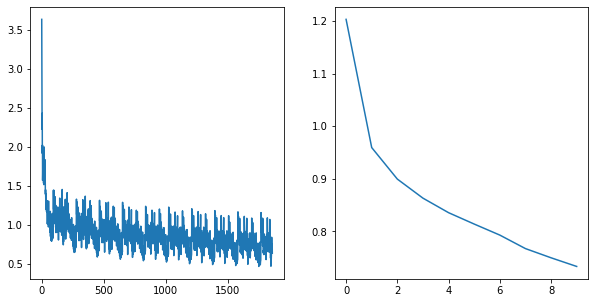

In [ ]:
import matplotlib as plt
fig, axes = plt.pyplot.subplots(1, 2, figsize=(10, 5))
axes[0].plot(stepLosses)
axes[1].plot(epochLosses)
print(f"Final Epochloss : {epochLosses[-1]}")

In [ ]:
torch.save(model.state_dict(), "UNetOnCity.pt")

## 4. Test.

In [ ]:
loadedModel = UNet(out_channels = 34).to(DEVICE)
loadedModel.load_state_dict(torch.load("/content/drive/MyDrive/UNetOnCity.pt"))

TEST_SIZE = 16
testLoader = DataLoader(testSet, batch_size = TEST_SIZE)
X, Y = next(iter(testLoader))
X, Y = X.to(device = DEVICE, dtype = torch.float), Y.to(device = DEVICE, dtype = torch.uint8)
Y_pred = loadedModel(X)
print(X.shape, Y.shape, Y_pred.shape)

torch.Size([16, 3, 128, 256]) torch.Size([16, 128, 256]) torch.Size([16, 34, 128, 256])


In [ ]:
def colorMap(matrix, colorCodes):
    a, b = np.array(matrix).shape
    rst = np.zeros(tuple([a, b, 3]))
    for y in range(len(matrix)):
        for x in range(len(matrix[0])):
            rst[y][x] = colorCodes[matrix[y][x]]
    return rst

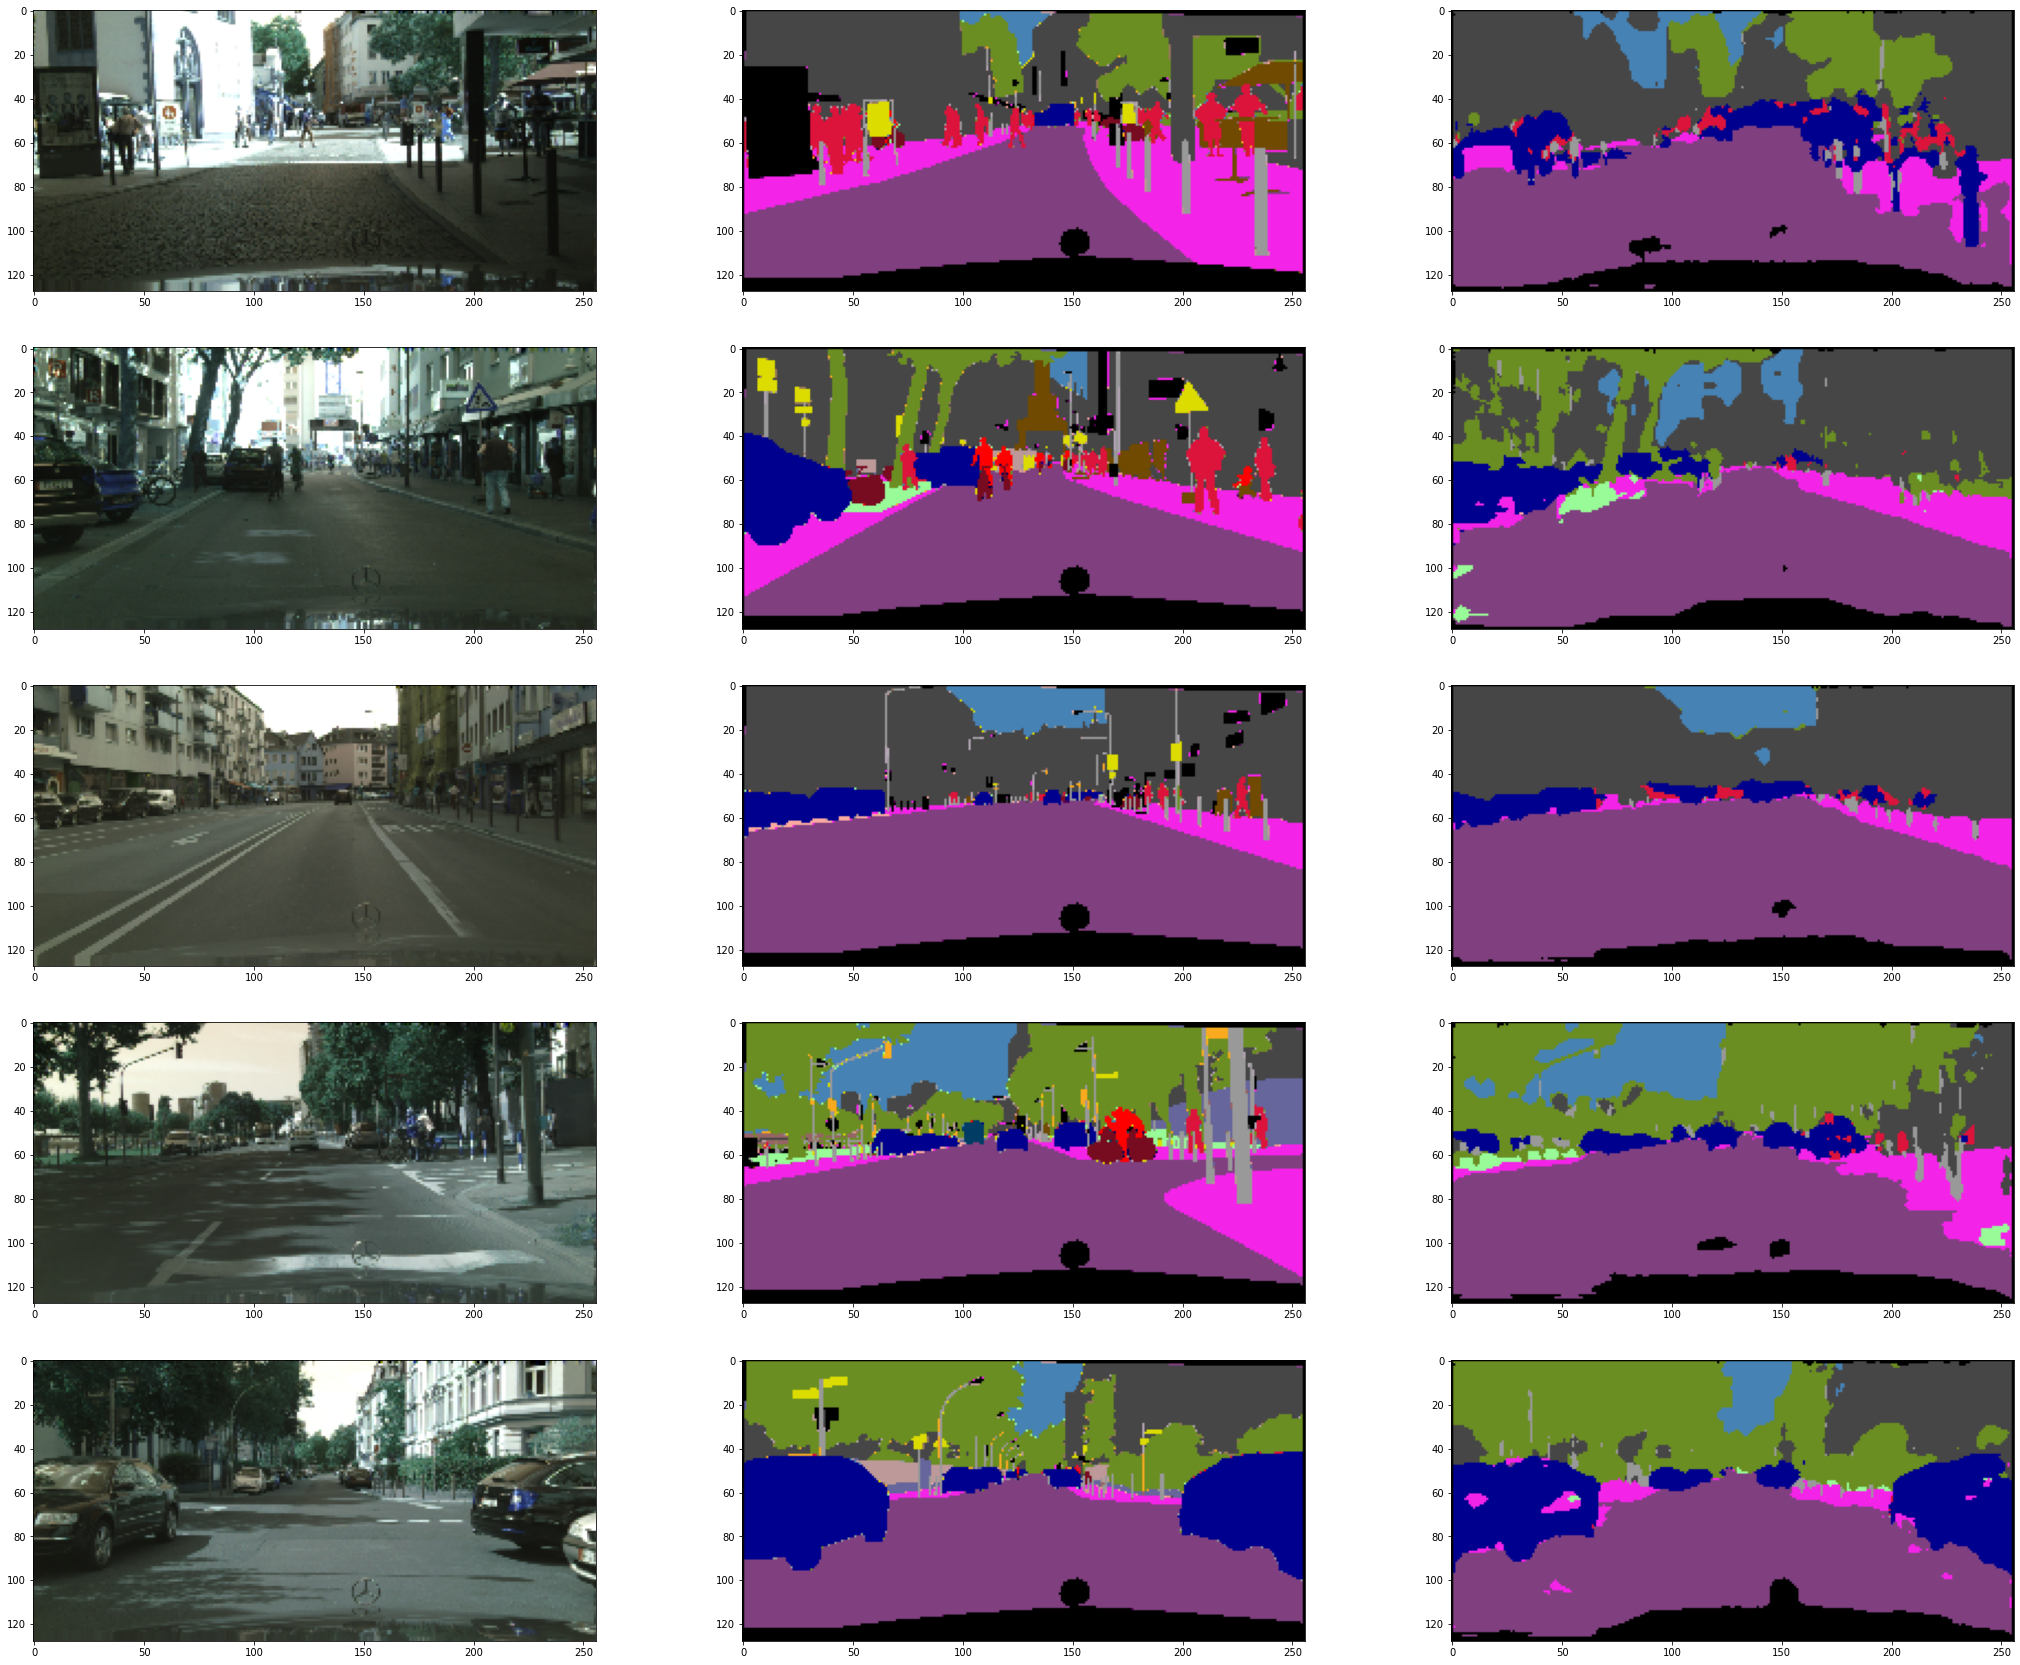

In [ ]:
fig, axes = plt.pyplot.subplots(5, 3, figsize = (12 * 3, 5 * 6))
for i in range(5):
    axes[i, 0].imshow((X[i].permute(1, 2, 0).cpu().detach().numpy()).astype(np.uint8))
    axes[i, 1].imshow((colorMap((Y[i].cpu().detach().numpy()).astype(np.uint8), testSet.color_codes)).astype(np.uint8) )
    axes[i, 2].imshow((colorMap(torch.argmax(Y_pred.cpu().detach(), dim = 1)[i], testSet.color_codes)).astype(np.uint8))

In [15]:
avgAcc = 0
aleatoric = 0
epistemicAll = np.zeros(34)
epistemicErr = np.zeros(34)

for X, Y in tqdm(testLoader, total = 2, leave=False):
    X, Y = X.to(device = DEVICE, dtype = torch.float), Y.to(device = DEVICE, dtype = torch.long)
    Y_pred = loadedModel(X)
    Y_pred2 = torch.argmax(Y_pred, dim = 1)
    batchAcc = 0
    for i in range(len(X)):
        correctCount = 0
        for y in range(len(Y[0])):
            for x in range(len(Y[0][0])):
                cls = Y[i][y][x]
                epistemicAll[cls] += 1
                if Y[i][y][x] == Y_pred2[i][y][x]:
                    correctCount += 1
                    aleatoric += (1 - Y_pred[i][cls][y][x])**2
                else:
                    epistemicErr[cls] += 1
                
        batchAcc += correctCount / (128 * 256)
    batchAcc /= TEST_SIZE
    avgAcc += batchAcc
    print(avgAcc)

  0%|          | 0/2 [00:00<?, ?it/s]

0.7700977325439453
1.5349655151367188


RuntimeError: ignored

In [16]:
avgAcc /= 2
print(f"Average accuracy on testset is : {avgAcc * 100:.2f}%")
print(f"Aleatoric uncentainty can be evaluated as : {aleatoric}")
print("For each class, the epistemic uncertanty can be evaluated as follows.")
for i in range(34):
    print(f"For class[{i}]: the epistemic uncertanty can be evaluated as : {epistemicErr[i] / epistemicAll[i] * 100:.2f}%")

Average accuracy on testset is : 76.75%
Aleatoric uncentainty can be evaluated as : 26958040.0
For each class, the epistemic uncertanty can be evaluated as follows.
For class[0]: the epistemic uncertanty can be evaluated as : 100.00%
For class[1]: the epistemic uncertanty can be evaluated as : 20.54%
For class[2]: the epistemic uncertanty can be evaluated as : 79.58%
For class[3]: the epistemic uncertanty can be evaluated as : 1.19%
For class[4]: the epistemic uncertanty can be evaluated as : 100.00%
For class[5]: the epistemic uncertanty can be evaluated as : 100.00%
For class[6]: the epistemic uncertanty can be evaluated as : 100.00%
For class[7]: the epistemic uncertanty can be evaluated as : 4.78%
For class[8]: the epistemic uncertanty can be evaluated as : 36.34%
For class[9]: the epistemic uncertanty can be evaluated as : 100.00%
For class[10]: the epistemic uncertanty can be evaluated as : 100.00%
For class[11]: the epistemic uncertanty can be evaluated as : 12.88%
For class[12]